## Calculate some information about phage lengths

This is mostly Toni Luque's fault. But don't blame him

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import subprocess
import gzip

### Read the raw data.

The data is in a bit of an "odd" format - there is a column with the prophage type
either kept (i.e. real); no phage gene (i.e. we had no hit to vogs and nothing annotated
as a phage gene), or not enough genes.

When we ran phispy we used:
 - min_contig_size=5000
 - nonprophage_genegaps=10
 - phage_genes=1 -- this is the minimum number of phage genes. If we are less than this (i.e. 0) we are dropped with "Dropped No genes were identified as phage genes" and they are included in the table as "No phage genes"
 - number=5 -- this is the minimum number of genes in the region. If we are less than this, we are dropped with "Dropped. Not enough genes" and they are included in the table as "No genes"
 
If we had >= 1 phage gene and >= 5 genes then they are included in the table as "Kept" and we think they are a real prophage.

Therefore we would expect "No genes" to be less than ~5kb max. We would expect "No phage genes" to be shorter than
prophages overall.

Because of this format, we are not going to use pandas (yet) to read the data. We will just read them into a dict of arrays.

In [2]:
data = {"Kept" : [], "No genes" : [], "No phage genes" : []}
with gzip.open("../data/phage_lengths.tsv.gz", "rt") as f:
    for l in f:
        p = l.strip().split("\t")
        data[p[0]].append(int(p[1]))
for k in data:
    print(f"We added {len(data[k])} '{k}' records")

We added 368254 'Kept' records
We added 1799778 'No genes' records
We added 594806 'No phage genes' records


### Plot all predicted prophages

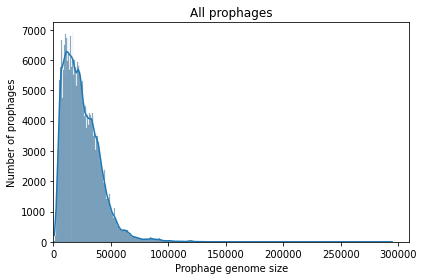

In [4]:
ax = sns.histplot(data['Kept'], kde=True)
ax.set_xlim(0, )
ax.set_ylim(0, )
ax.set_xlabel('Prophage genome size')
ax.set_ylabel('Number of prophages')
ax.set_title("All prophages")
plt.tight_layout() 

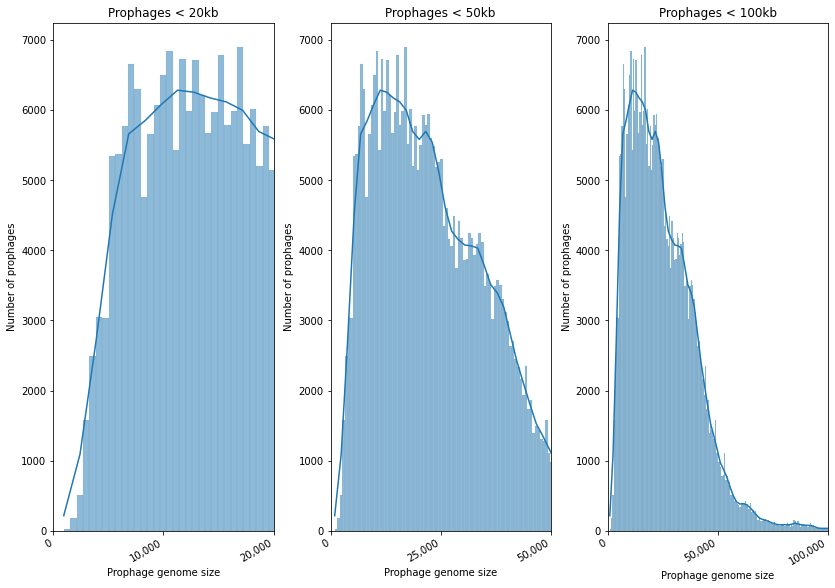

In [8]:
fig, ax = plt.subplots(1,3, figsize=(11.7,8.27))

for a in ax:
    sns.histplot(data['Kept'], ax=a, kde=True)

ax[2].set_xlim(0, 100000)
ax[1].set_xlim(0, 50000)
ax[0].set_xlim(0, 20000)

ax[2].set_title("Prophages < 100kb")
ax[1].set_title("Prophages < 50kb")
ax[0].set_title("Prophages < 20kb")

label_format = '{:,.0f}'

for a in ax:
    a.set_ylim(0, )
    a.set_xlabel('Prophage genome size')
    a.set_ylabel('Number of prophages')
    a.xaxis.set_major_locator(mticker.MaxNLocator(2))
    ticks_loc = a.get_xticks().tolist()
    a.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    a.set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=30, horizontalalignment='right')


plt.tight_layout() 
fig.savefig('images/prophage_sizes.png')

ax: 0 data: Kept
ax: 1 data: No phage genes
ax: 2 data: No genes


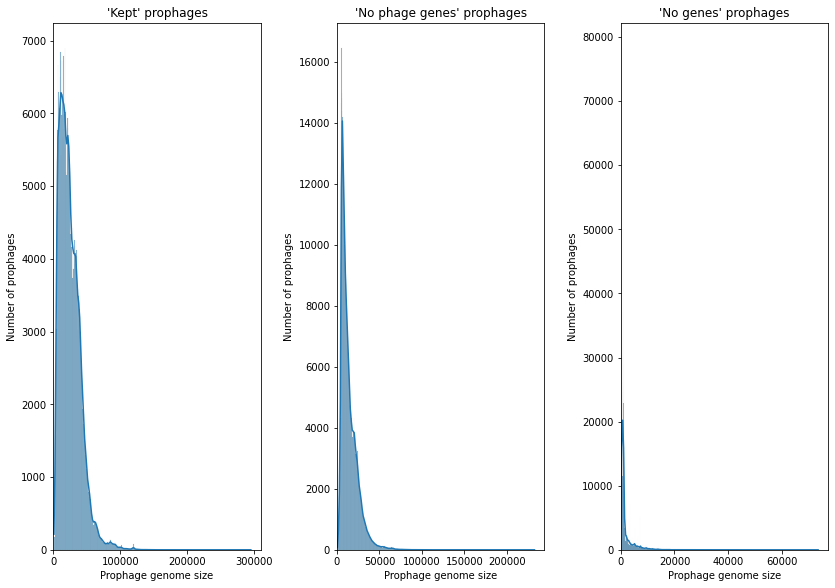

In [11]:
fig, ax = plt.subplots(1,3, figsize=(11.7,8.27))

for i, j in enumerate(["Kept", "No phage genes", "No genes"]):
    print(f"ax: {i} data: {j}")
    sns.histplot(data[j], kde=True, ax=ax[i])
    ax[i].set_xlim(0, )
    ax[i].set_ylim(0, )
    ax[i].set_xlabel('Prophage genome size')
    ax[i].set_ylabel('Number of prophages')
    ax[i].set_title(f"'{j}' prophages")



plt.tight_layout() 
fig.savefig('images/prophage_prediction_lengths.png')

### Focus on 20-30 kb

Because I am interested in this region!

In [34]:
minx = 15000
maxx = 45000
sel = [x for x in data['Kept'] if x > minx and x < maxx]
print(f"We selected {len(sel):,} from {len(data['Kept']):,} values")

We selected 219,479 from 368,254 values


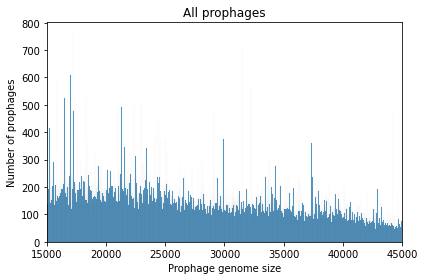

In [40]:
ax = sns.histplot(sel, binwidth=20)
ax.set_xlim(minx, maxx)
ax.set_ylim(0, )
ax.set_xlabel('Prophage genome size')
ax.set_ylabel('Number of prophages')
ax.set_title("All prophages")
plt.tight_layout() 

In [38]:
counts = [0] * (maxx-minx)
for c in sel:
    counts[c-minx] += 1

print(f"The most in the region from {minx:,} to {maxx:,}: {max(counts)} at {counts.index(max(counts)) + minx:,} bp long")


The most in the region from 15,000 to 45,000: 561 at 17,178 bp long


### Find some simple peaks


In [41]:
minx = 35000
maxx = 45000
sel = [x for x in data['Kept'] if x > minx and x < maxx]
print(f"We selected {len(sel):,} from {len(data['Kept']):,} values")
counts = [0] * (maxx-minx)
for c in sel:
    counts[c-minx] += 1

print(f"The most in the region from {minx:,} to {maxx:,}: {max(counts)} at {counts.index(max(counts)) + minx:,} bp long")


We selected 49,874 from 368,254 values
The most in the region from 35,000 to 45,000: 299 at 44,271 bp long
